In [ ]:
!pip install librosa --quiet
!pip install matplotlib --quiet

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
AUDIO_BASE_DIR = "/content/drive/MyDrive/birdclef-2025/train_audio"
OUTPUT_BASE_DIR = "/content/drive/MyDrive/birdclef-2025/spectrograms"
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

In [ ]:
def save_mel_spectrogram(file_path, output_path):
    try:
        y, sr = librosa.load(file_path, sr=32000)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(2.56, 2.56), dpi=100)
        librosa.display.specshow(S_dB, sr=sr, x_axis=None, y_axis=None, cmap='magma')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"⚠️ Ошибка при обработке {file_path}: {e}")

In [90]:
from tqdm import tqdm
import os

AUDIO_BASE_DIR = "/content/drive/MyDrive/birdclef-2025/train_audio"
OUTPUT_BASE_DIR = "/content/drive/MyDrive/birdclef-2025/spectrograms"

os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)


for fname in tqdm(os.listdir(AUDIO_BASE_DIR)):
    if fname.endswith(".ogg"):
        in_path = os.path.join(AUDIO_BASE_DIR, fname)
        out_name = fname.replace(".ogg", ".png")
        out_path = os.path.join(OUTPUT_BASE_DIR, out_name)
        save_mel_spectrogram(in_path, out_path)

100%|██████████| 341/341 [03:27<00:00,  1.64it/s]


In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


DATA_DIR = "/content/drive/MyDrive/birdclef-2025/spectrograms"


IMG_SIZE = (256, 256)
BATCH_SIZE = 16


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 246 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#  CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,764,610 (60.14 MB)

 Trainable params: 15,764,610 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
EPOCHS = 15

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5798 - loss: 3.1604 - val_accuracy: 0.6167 - val_loss: 0.6646
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8172 - loss: 0.4619 - val_accuracy: 0.5667 - val_loss: 1.0057
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7451 - loss: 0.5975 - val_accuracy: 0.6500 - val_loss: 0.8993
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8394 - loss: 0.3878 - val_accuracy: 0.6333 - val_loss: 0.7585
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9169 - loss: 0.2384 - val_accuracy: 0.6500 - val_loss: 1.0889
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9363 - loss: 0.1691 - val_accuracy: 0.6667 - val_loss: 1.1198
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9582 - loss: 0.1181 - val_accuracy: 0.6500 - val_loss: 1.0934
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9519 - loss: 0.1056 - val_accuracy: 0.6667 - val_loss:

In [97]:
model.save("/content/drive/MyDrive/birdclef-2025/bird_vs_frog_model.h5")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


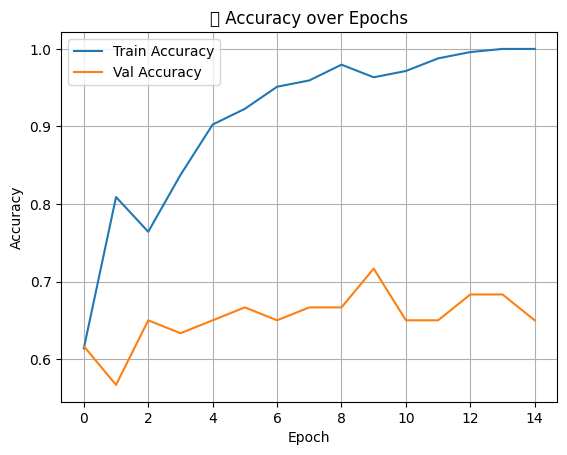

In [98]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('📈 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
spectrograms_dir = "/content/drive/MyDrive/birdclef-2025/spectrograms"

In [108]:
import os

spectrograms_dir = "/content/drive/MyDrive/birdclef-2025/spectrograms"
spectrograms = [f for f in os.listdir(spectrograms_dir) if f.endswith('.png')]

print("🎯 Number of files:", len(spectrograms))
print("🖼️ First 5 spectrograms:", spectrograms[:5])

🎯 Number of files: 341
🖼️ First 5 spectrograms: ['CSA18794.png', 'CSA18802.png', 'CSA36388.png', 'CSA18783.png', 'CSA36373.png']


In [107]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

img_path = "/content/drive/MyDrive/birdclef-2025/spectrograms/CSA18794.png"

model = load_model("/content/drive/MyDrive/birdclef-2025/bird_vs_frog_model.h5")

img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

class_labels = ['bird', 'frog']

print(f"🧠 On spectrogram '{img_path.split('/')[-1]}' — it is: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
🧠 On spectrogram 'CSA18794.png' — it is: frog


In [111]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


model_path = "/content/drive/MyDrive/birdclef-2025/bird_vs_frog_model.h5"
spectrograms_dir = "/content/drive/MyDrive/birdclef-2025/spectrograms"


model = load_model(model_path)


class_labels = ['bird', 'frog']

In [112]:

spectrogram_files = sorted([f for f in os.listdir(spectrograms_dir) if f.endswith('.png')])


submission_rows = []


for fname in spectrogram_files:
    img_path = os.path.join(spectrograms_dir, fname)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    label = class_labels[predicted_class]

    submission_rows.append({'filename': fname, 'label': label})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━

In [113]:
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("/content/drive/MyDrive/birdclef-2025/submission.csv", index=False)

print("✅ submission.csv saved successfully!")
submission_df.head()

✅ submission.csv saved successfully!


,filename,label
0,CSA18783.png,frog
1,CSA18794.png,frog
2,CSA18802.png,frog
3,CSA34180.png,frog
4,CSA34181.png,bird


In [114]:
from google.colab import drive
drive.mount('/content/drive')

!pip install librosa --quiet
!pip install soundfile --quiet

import os
import librosa
import numpy as np
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
!pip install tensorflow --quiet

In [116]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os

# Путь к спектрограммам
SPECTROGRAMS_DIR = "/content/drive/MyDrive/birdclef-2025/spectrograms"

# Загрузка модели
model = load_model("/content/drive/MyDrive/birdclef-2025/bird_vs_frog_model.h5")

# Все .png спектрограммы
files = sorted([f for f in os.listdir(SPECTROGRAMS_DIR) if f.endswith('.png')])

# Предсказания
submission_rows = []

for fname in files:
    img_path = os.path.join(SPECTROGRAMS_DIR, fname)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0]

    submission_rows.append({
        'row_id': fname,
        'bird': prediction[0],
        'frog': prediction[1]
    })

# Создание submission DataFrame в формате Kaggle
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("/content/drive/MyDrive/birdclef-2025/submission.csv", index=False)

print("✅ submission.csv created in official Kaggle format!")
submission_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━

,row_id,bird,frog
0,CSA18783.png,0.390047,0.609953
1,CSA18794.png,0.000173,0.999827
2,CSA18802.png,0.025071,0.974929
3,CSA34180.png,0.036797,0.963203
4,CSA34181.png,0.999820,0.000180
